## Intro To ML
## Final Project
## Ron Segev & Ofir Asher

# Importing Data

In [1]:
#import necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tabulate import tabulate
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read the data
train_raw = pd.read_csv("train.csv")
X_train_raw = train_raw.iloc[:,:-1]
Y_train_raw = train_raw.iloc[:,-1]

# Split the data into train and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X_train_raw,Y_train_raw)
#putsha256 on side for val
sha256_val = X_validation.iloc[:, 0]
X_train = X_train.iloc[:,1:]
X_validation = X_validation.iloc[:,1:]
    

-----------------------------
# 1. Exploration Phase


### Correlation

For our first basic exploration of this dataset, we want to analyze correlation between features (and the label)


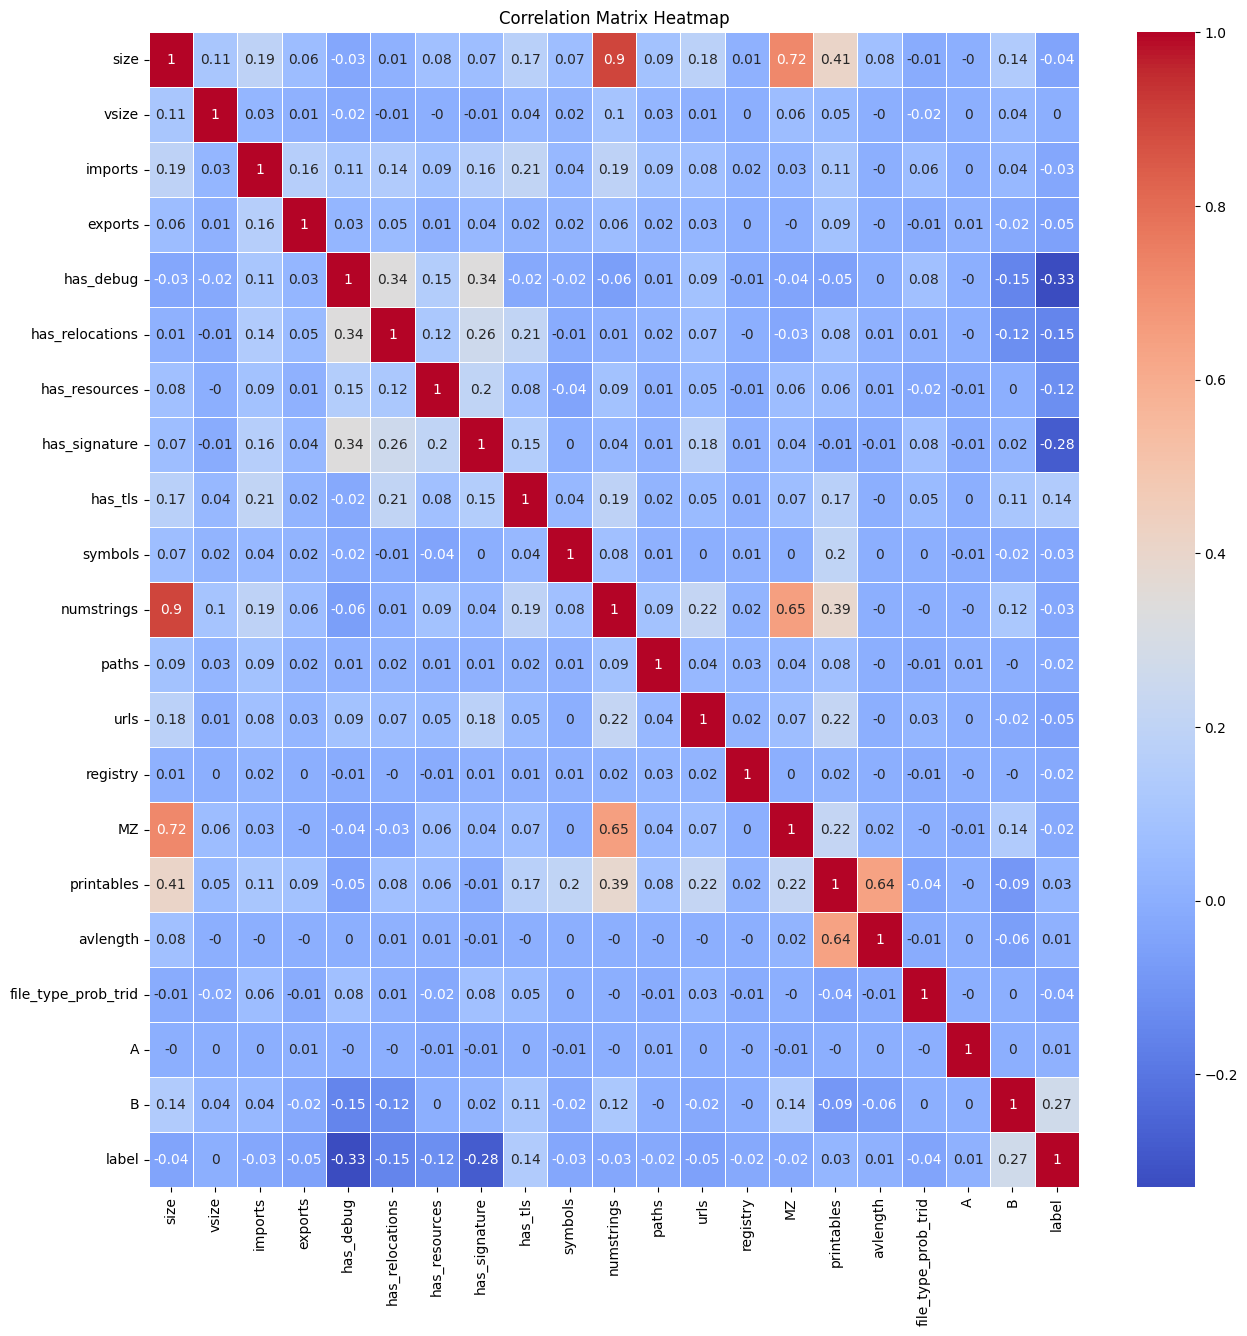

In [3]:
# Correlation matrix heatmap
correlation_matrix = train_raw.corr(numeric_only=True).round(2)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Based on the correlation matrix, we can observe that the "size" feature has a strong positive correlation of 0.9 with the "numstrings" feature. This indicates that as the file size increases, the number of strings in the file also tends to increase. Additionally, the "size" feature has a moderate positive correlation of 0.73 with the "MZ" feature. This suggests that as the file size increases, the occurrences of the string "MZ" within the file also tend to increase. These correlations may provide valuable insights into the relationship between these features and could be useful in understanding the characteristics of malicious and non-malicious files. The correlation matrix also shows that our label has a negative correlation of -0.33 with the "has_debug" feature, indicating that as the value of "has_debug" increases, the likelihood of the file being malicious decreases. In other words, files with a debug section are less likely to be malicious.

Similarly, the label has a negative correlation of -0.28 with the "has_signature" feature. This means that as the value of "has_signature" increases, the probability of the file being malicious also decreases. In other words, files with a signature are less likely to be malicious.

These negative correlations suggest that the presence of a debug section and a signature in a file may serve as indicators of non-malicious files.

### Statistics


Summary stats for each continuous feature

In [4]:
# Summary statistics for each feature
summary_stats = X_train_raw.describe().transpose().round(1)
table = tabulate(summary_stats, headers='keys', tablefmt='pretty')
print("Summary Statistics for each feature:")
print(table)

Summary Statistics for each feature:
+---------------------+---------+-----------+------------+-------+----------+----------+-----------+--------------+
|                     |  count  |   mean    |    std     |  min  |   25%    |   50%    |    75%    |     max      |
+---------------------+---------+-----------+------------+-------+----------+----------+-----------+--------------+
|        size         | 60000.0 | 1501019.1 | 4727390.7  | 298.0 | 107008.0 | 483328.0 | 1239326.0 | 325353693.0  |
|        vsize        | 58065.0 | 1965704.3 | 20178814.6 | 544.0 | 122880.0 | 421888.0 | 1601536.0 | 4278288384.0 |
|       imports       | 58261.0 |   106.2   |   213.5    |  0.0  |   1.0    |   28.0   |   152.0   |   15047.0    |
|       exports       | 57907.0 |   30.8    |   508.1    |  0.0  |   0.0    |   0.0    |    0.0    |   48840.0    |
|      has_debug      | 57073.0 |    0.4    |    0.5     |  0.0  |   0.0    |   0.0    |    1.0    |     1.0      |
|   has_relocations   | 56676.0 |  

Based on the summary statistics for the size feature, we can observe the following:

The size feature has a wide range of values, with a minimum of 298 and a maximum of 325,353,693. The mean file size is about 1,501,019, while the median is 483,328. The distribution of this feature is likely to be right-skewed, as the mean is greater than the median. Right-skewed, also known as positively skewed, means that the tail of the distribution extends towards larger values. In this case, the mean is greater than the median, indicating that there are relatively more larger file sizes compared to smaller ones. A similar observation can be made for vsize



### Distribution of Continuous Variables

We will check  distribution of continuous variables in order to see which statistical methods we can use in preprocessing, as many require normal distribution.

In [5]:
# Select numeric columns from train_raw
numeric_columns = train_raw.select_dtypes(include='number').columns

# Filter out non-continuous variables
continuous_columns = []
for column in numeric_columns:
    if train_raw[column].nunique() > 2:  # Adjust the threshold as needed
        continuous_columns.append(column)

# Initialize an empty list to store the results
results = []

# Iterate over each continuous column
for column in continuous_columns:
    # Make a copy of the column data and remove missing values
    data = train_raw[column].copy().dropna()

    # Perform Kolmogorov-Smirnov test
    stat, p = stats.kstest(data, 'norm', alternative='two-sided')
    results.append([column, stat, p])

# Display results in a table
headers = ["Column", "K-S Statistic", "p-value"]
print(tabulate(results, headers=headers, floatfmt=".4f", tablefmt='pretty'))

+---------------------+--------------------+---------+
|       Column        |   K-S Statistic    | p-value |
+---------------------+--------------------+---------+
|        size         |        1.0         |   0.0   |
|        vsize        |        1.0         |   0.0   |
|       imports       | 0.7325584224558346 |   0.0   |
|       exports       |        0.5         |   0.0   |
|       symbols       |        0.5         |   0.0   |
|     numstrings      | 0.9983184096391915 |   0.0   |
|        paths        |        0.5         |   0.0   |
|        urls         |        0.5         |   0.0   |
|      registry       |        0.5         |   0.0   |
|         MZ          | 0.8413447460685429 |   0.0   |
|     printables      | 0.9999997133484281 |   0.0   |
|      avlength       | 0.9999997133484281 |   0.0   |
| file_type_prob_trid |        1.0         |   0.0   |
|          A          | 0.5879427438956808 |   0.0   |
|          B          | 0.995878636498666  |   0.0   |
+---------

The code calculates the Kolmogorov-Smirnovv test (not learned in class) for each continuous column in the raw dataset. The test compares the distribution of each column against a normal distribution. The test statistic (K-S statistic) measures the maximum difference between the cumulative distribution function (CDF) of the data and the CDF of the normal distribution.

The results are displayed in a table, including the column name, K-S statistic, and p-value. The K-S statistic represents the maximum distance between the empirical distribution function of the data and the theoretical distribution (in this case, the normal distribution). The p-value indicates the probability of observing a K-S statistic as extreme as the one obtained under the null hypothesis (the data follows a normal distribution).

Interpreting the results:

For the "size" column, the K-S statistic is 1.0, indicating a significant difference between the distribution of the data and a normal distribution. The p-value is 0.0, suggesting strong evidence against the data following a normal distribution.
The same pattern applies to other columns like "vsize," "imports," "exports," "symbols," "numstrings," "paths," "urls," "registry," "MZ," "printables," "avlength," "file_type_prob_trid," "A," and "B." The K-S statistics are close to 1.0, indicating significant deviations from a normal distribution, and the p-values are 0.0, indicating strong evidence against the null hypothesis of normality.
In summary, based on the K-S statistics and p-values obtained from the Kolmogorov-Smirnov test, it can be concluded that the distribution of the data in these columns significantly deviates from a normal distribution. The low p-values suggest that these columns are not normally distributed and have different characteristics.

### Binary Variables

Since these variables are not continuous, we cannot use the statistical test from before. We will check frequency of [0,1] for each binary feature.

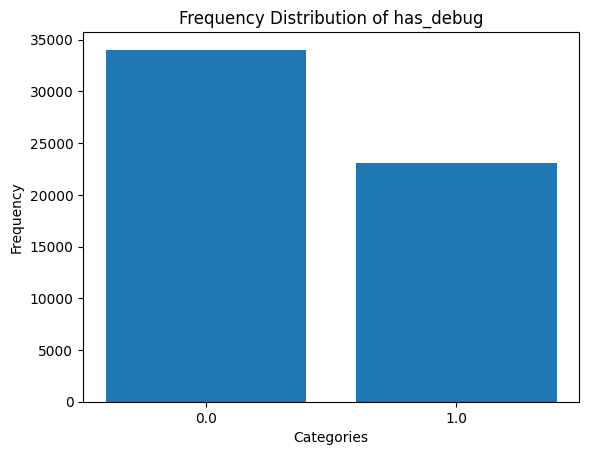

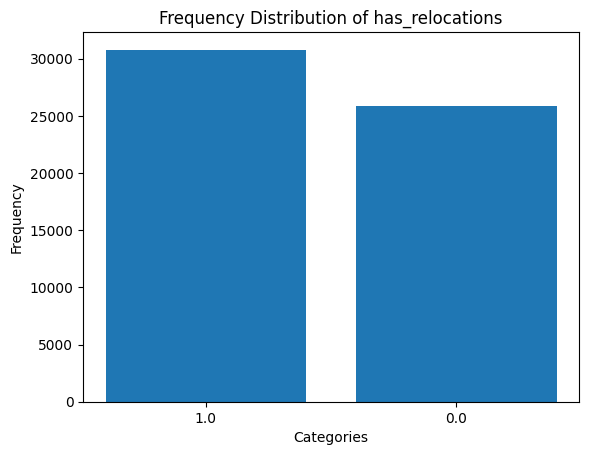

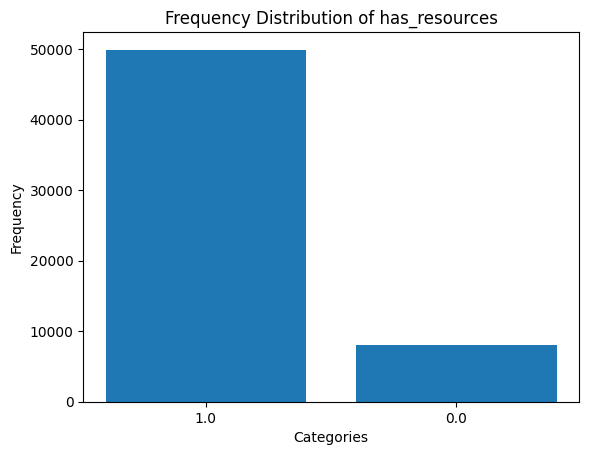

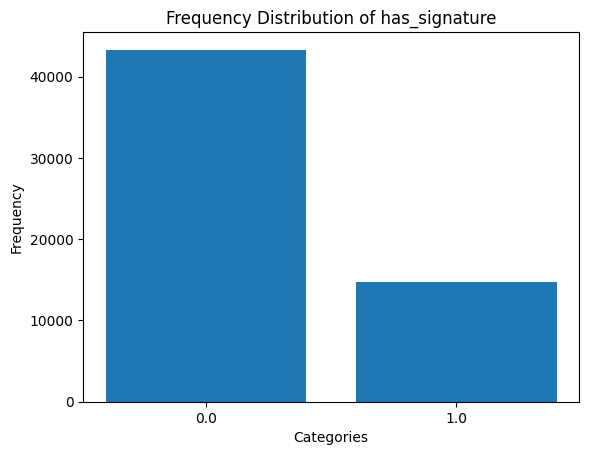

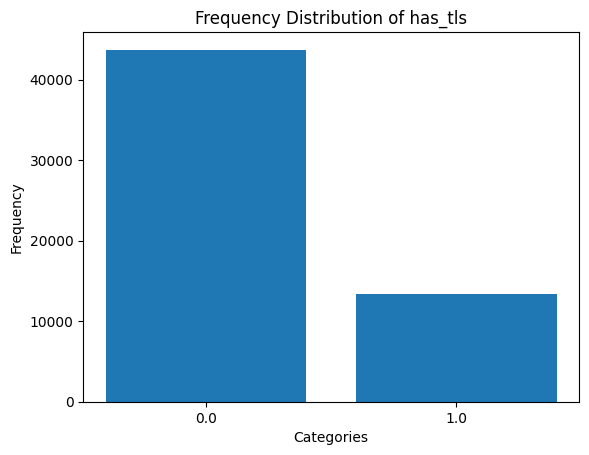

In [6]:


binary_columns = ['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']

for column in binary_columns:
    frequency_table = train_raw[column].value_counts()

    # Plotting the frequency distribution as a bar chart
    plt.bar(frequency_table.index.astype(str), frequency_table.values)
    plt.xlabel('Categories')
    plt.ylabel('Frequency')
    plt.title(f'Frequency Distribution of {column}')
    plt.show()


Three interesting observations here relate to has_resources,has_signature, and has_tls. 

has_resources: More "1" (with) than "0" (without). 

has_signature: More "0" (without) than "1" (with). 

has_tls: More "0" (without) than "1" (with). 

We will now show results per label

In [7]:
# Convert relevant columns to string for better column names in the output
train_raw['has_signature'] = train_raw['has_signature'].astype(str)
train_raw['has_resources'] = train_raw['has_resources'].astype(str)
train_raw['has_tls'] = train_raw['has_tls'].astype(str)

# Remove rows with missing values
train_raw_copy = train_raw.dropna()

# Create crosstab tables
table_signature = pd.crosstab(train_raw_copy['has_signature'], train_raw_copy['label'])
table_resources = pd.crosstab(train_raw_copy['has_resources'], train_raw_copy['label'])
table_tls = pd.crosstab(train_raw_copy['has_tls'], train_raw_copy['label'])

# Rename the columns 
table_signature.columns = ['has_signature_0_{}'.format(i) for i in table_signature.columns]
table_resources.columns = ['has_resources_0_{}'.format(i) for i in table_resources.columns]
table_tls.columns = ['has_tls_0_{}'.format(i) for i in table_tls.columns]

# Display the table for has_signature
print("Table for has_signature:")
table_signature_without_last_row = table_signature.iloc[:-1, :]
print(tabulate(table_signature_without_last_row, headers='keys', tablefmt='psql'))
print()

# Display the table for has_resources
print("Table for has_resources:")
table_resources_without_last_row = table_resources.iloc[:-1, :]
print(tabulate(table_resources_without_last_row, headers='keys', tablefmt='psql'))
print()

# Display the table for has_tls
print("Table for has_tls:")
table_tls_without_last_row = table_tls.iloc[:-1, :]
print(tabulate(table_tls_without_last_row, headers='keys', tablefmt='psql'))

Table for has_signature:
+-----------------+---------------------+---------------------+
|   has_signature |   has_signature_0_0 |   has_signature_0_1 |
|-----------------+---------------------+---------------------|
|               0 |                8115 |               12532 |
|               1 |                4857 |                1873 |
+-----------------+---------------------+---------------------+

Table for has_resources:
+-----------------+---------------------+---------------------+
|   has_resources |   has_resources_0_0 |   has_resources_0_1 |
|-----------------+---------------------+---------------------|
|               0 |                1262 |                2656 |
|               1 |               11700 |               11730 |
+-----------------+---------------------+---------------------+

Table for has_tls:
+-----------+---------------+---------------+
|   has_tls |   has_tls_0_0 |   has_tls_0_1 |
|-----------+---------------+---------------|
|         0 |         1

Results:

has_signature: It seems as if not having a signature increased the likelihood of being malware

has_resources: Out of those with resources, almost half are malware and half arent. While for those without resources, there are more that are malware. This shows that having resources does not give us a clear understanding of malware detection

has_tls: Same results as has_resources, but opposite. Maybe having tls increases chance of being malware, but not having tls splits it to 50/50.

### File Type Trid

This categorical variable cannot be directly translated into a machine learning model. Before preprocessing, we will analyze file type percentages

In [8]:
# Calculate the percentage of each file type
file_type_counts = train_raw['file_type_trid'].value_counts()
total_files = file_type_counts.sum()
file_type_percentage = file_type_counts / total_files * 100

# Exclude file types with 0% occurrence
file_type_percentage = file_type_percentage[file_type_percentage > 0]

# Categorize file types below the threshold as "Other"
threshold = 1  
other_percentage = file_type_percentage[file_type_percentage < threshold].sum()
file_type_percentage.loc[file_type_percentage < threshold] = 0
file_type_percentage['Other'] = other_percentage

# Normalize percentages to ensure the sum is 100%
non_zero_percentage_sum = file_type_percentage.sum()
file_type_percentage = file_type_percentage / non_zero_percentage_sum * 100

# Display the percentage for each file type
for file_type, percentage in file_type_percentage.iteritems():
    if percentage > 0:
        print(f"{file_type}: {percentage:.2f}%")


Win64 Executable (generic): 16.81%
Win32 Executable MS Visual C++ (generic): 14.95%
Win32 Executable (generic): 14.64%
Win32 Dynamic Link Library (generic): 6.68%
Generic CIL Executable (.NET, Mono, etc.): 6.34%
Windows Control Panel Item (generic): 5.35%
InstallShield setup: 3.69%
UPX compressed Win32 Executable: 3.67%
DOS Executable Generic: 2.87%
Win32 Executable Microsoft Visual Basic 6: 2.78%
OS/2 Executable (generic): 1.96%
Win32 EXE PECompact compressed (generic): 1.93%
Generic .NET DLL/Assembly: 1.92%
WinRAR Self Extracting archive (4.x-5.x): 1.85%
NSIS - Nullsoft Scriptable Install System: 1.73%
Microsoft Visual C++ compiled executable (generic): 1.65%
Win32 Executable Delphi generic: 1.47%
Inno Setup installer: 1.36%
Win16 NE executable (generic): 1.29%
Windows ActiveX control: 1.15%
Other: 5.92%


Using a threshold of 1%, we now narrowed down the file types to 6 and an "other" category. This way, if we choose to use One-Hot Encoding later we have reduced dimensionality

In the same way we will now we will analyze 'C', an unknown categorial variable

In [9]:
# Calculate the percentage of each file type
file_type_counts = train_raw['C'].value_counts()
total_files = file_type_counts.sum()
file_type_percentage = file_type_counts / total_files * 100

# Exclude file types with 0% occurrence
file_type_percentage = file_type_percentage[file_type_percentage > 0]

# Categorize file types below the threshold as "Other"
threshold = 1  
other_percentage = file_type_percentage[file_type_percentage < threshold].sum()
file_type_percentage.loc[file_type_percentage < threshold] = 0
file_type_percentage['Other'] = other_percentage

# Normalize percentages to ensure the sum is 100%
non_zero_percentage_sum = file_type_percentage.sum()
file_type_percentage = file_type_percentage / non_zero_percentage_sum * 100

# Display the percentage for each file type
for file_type, percentage in file_type_percentage.iteritems():
    if percentage > 0:
        print(f"{file_type}: {percentage:.2f}%")

vh: 40.08%
er: 19.97%
cs: 10.26%
bf: 9.99%
gow: 9.76%
mc: 8.90%
vr: 1.04%


We now narrowed down the C types to 7 categories, and there are no types below the threshold("Other").

This way, if we choose to use One-Hot Encoding later we can.

# 2. Preprocessing

### a) Outliers



We want to generate a function that removes outliers in the data that can skew the results of our model

We chose not to use the learned IQR method since it assumes that the data is approximately normally distributed. (We proved before that this does not apply to our data)

Another approach is to use the Median Absolute Deviation (MAD), which is less sensitive to extreme values and does not assume a normal distribution.

The Median Absolute Deviation (MAD) is a robust measure of variability in a data set, and it can be used to detect outliers. The idea is that if a data point is far from the median value of a data set, it might be an outlier. The MAD is less sensitive to extreme values than the standard deviation, and so it's often a better choice for detecting outliers in skewed distributions (which is what we observed before).

In [10]:
def mad_score(series):
    median = series.median()
    mad = np.median(np.abs(series - median))
    return 1.4826 * (series - median) / mad


def mad(X_train, y_train):
    # Set a threshold to define outliers, e.g. 5 for MAD
    mad_threshold = 8

    # Select only the numeric columns from the X_train dataset
    numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
    X_train_numeric = X_train[numeric_columns]

    # Identify potential outliers using the MAD method on X_train
    mad_outliers_X = X_train_numeric.apply(mad_score) > mad_threshold

    outliers_mask = ~mad_outliers_X.any(axis=1)

    # Filter X_train and y_train based on outliers_mask
    outliers_X_train = X_train.loc[outliers_mask]
    outliers_y_train = y_train.loc[outliers_mask]
    
    return outliers_X_train, outliers_y_train

X_outliers_train, y_outliers_train = mad(X_train, y_train)
print(np.shape(X_outliers_train))






(38878, 22)


We are now left with less values. We use this new dataset for training, so that we do not learn from outliers.

### b) **Feature Engineering**

Interactions: Debug and Relocations/Signature

Since both the has_debug & has_relocation/signature features have a high correlation and represent the presence of certain characteristics in our data, an interaction between these two features might capture more information. What we create here are dummy variables that can be used to add to our model these features combined. For example, there might be significant differences in the instances where both debugging and relocations are present compared to when only one or neither is present.

In [11]:
def feature_engineering(X):
        #feature interaction
        X['debug_and_relocations'] = X['has_debug'] * X['has_relocations']
        X['debug_and_signature'] = X['has_debug'] * X['has_relocations']
        return X
    
X_new_features = feature_engineering(X_outliers_train)

### c) Normalization

In [12]:
X_to_normalize = X_new_features.copy()
def check_normalize(X):
    numerical_features = X.select_dtypes(include=[np.number])
    feature_list = numerical_features.columns.tolist()  # List of numerical features
    return feature_list
numerical_features_list = check_normalize(X_to_normalize)




From the summary statistics shown in the exploration phase, it appears that our features have different scales and ranges. 

In addition to the ranges and scales mentioned earlier, we can also observe the differences in the mean and median values of the features. 
These differences indicates a skewed distribution(As shown before). 

To determine if the data should be normalized, we need to consider the following factors:

Algorithms: Some machine learning algorithms, such as linear regression, k-nearest neighbors, and neural networks, are sensitive to the scale of the input features. In such cases, normalization helps the algorithm converge faster and often improves performance.

Interpretability: Normalized data can make it easier to interpret the relative importance of features, especially in linear models or when comparing coefficients.

For our specific problem, we plan to use machine learning algorithms that can be sensitive to unnormalized data. 

Given this and the statistics shown before, we decided to normalize all continuous features.



In [13]:
def normalize_train(X, feature_list):
    min_dict = {}
    max_dict = {}
    for feature in feature_list:
        min_val = X[feature].min()
        max_val = X[feature].max()
        X[feature] = (X[feature] - min_val) / (max_val - min_val)
        min_dict[feature] = min_val
        max_dict[feature] = max_val
    return X, min_dict, max_dict
X_normalized_df,min_dict,max_dict = normalize_train(X_to_normalize,numerical_features_list)


In [14]:
def normalize_test(X, feature_list, min_dict, max_dict):
    # Normalizing specific features in the test set
    for feature in feature_list:
        X[feature] = (X[feature] - min_dict[feature]) / (max_dict[feature] - min_dict[feature] + 1e-8)
    return X

#for running on test later

### d) Missing Values

We now check for missing values in our train set.

In [15]:
def missing_values(X):
    # Check for missing values
    missing_values = X.isnull().sum()

    # Display the count of missing values for each feature
    print(missing_values)
missing_values(X_normalized_df)

size                        0
vsize                    1253
imports                  1096
exports                  1357
has_debug                1909
has_relocations          2120
has_resources            1277
has_signature            1238
has_tls                  1896
symbols                  1756
numstrings               1791
paths                    2357
urls                     1509
registry                 1680
MZ                       2059
printables               1757
avlength                 1738
file_type_trid              0
file_type_prob_trid         0
A                        2434
B                        2445
C                        1292
debug_and_relocations    3925
debug_and_signature      3925
dtype: int64


As we can see, there are missing values in certain features. Therefore, we chose to impute missing values by filling them in with the mean of its corresponding feature.

In [16]:
def fill_na_mean_train(train):
    na_means = {}  # Dictionary to store the mean values for each column

    # Fill NA values with column means in the train set
    filled_na_train = train.fillna(train.mean())

    # Calculate and store the mean values for each column in the train set
    na_means = filled_na_train.mean().to_dict()

    return filled_na_train, na_means


def fill_na_mean_test(test, na_means):
    # Fill NA values in the test set using the means calculated from the train set
    filled_na_test = test.fillna(na_means)
    return filled_na_test

X_na_filled_df = X_normalized_df.copy()
X_na_filled_df,mean_dict = fill_na_mean_train(X_normalized_df)

#mean_dict is the dictionary of columns mean, need for later to run on test


Imputing missing values with the mean is a good method because:

1. It is simple and easy to implement.
2. It maintains the overall distribution of the dataset, as it preserves the mean and variance of the feature with missing values.

In [17]:

# Check for missing values
missing_values = X_na_filled_df.isnull().sum()

# Display the count of missing values for each feature
print(missing_values)


size                        0
vsize                       0
imports                     0
exports                     0
has_debug                   0
has_relocations             0
has_resources               0
has_signature               0
has_tls                     0
symbols                     0
numstrings                  0
paths                       0
urls                        0
registry                    0
MZ                          0
printables                  0
avlength                    0
file_type_trid              0
file_type_prob_trid         0
A                           0
B                           0
C                        1292
debug_and_relocations       0
debug_and_signature         0
dtype: int64


As we can see, since C is a categorical and string type variable, there are still missing values. There is no mean to insert in missing cells. We will deal with this feature in the next section.

### e) Categorical Values

As seen previously, C is an unknown feature of string type and has 1742 missing values. Therefore, since we currently cannot find a way in which C will help our model, we will remove this feature. It is important to note that removing this feature will increase bias and reduce variance, as per the Bias-Variance tradeoff.

In [18]:
def drop_C(X):
    if 'C' in X.columns:
        X = X.drop("C",axis=1)
    return X
    
X_dropped_c = X_na_filled_df.copy()
X_dropped_c = drop_C(X_dropped_c)

Categorical variables require special attention in a machine learning model because they cannot be input directly into most models. The feature 'file_type_trid' is a non-numerical categorical feature. 
For now, we will remove this feature so it does not interfere with our model. 
For our first model, we will remove this feature. In the future, we will see if One-Hot Encoding of this feature (using the precentages calculated before) improves our model. In addition, we will remove the feature file_type_prob_trid, as there is no need for a probability without the actual file_type_trid feature.




In [19]:
def remove_file_type_trid(X):
  #remove both features
  if "file_type_trid"  and "file_type_prob_trid" in X:
    X = X.drop("file_type_trid",axis=1)
    X = X.drop("file_type_prob_trid",axis=1)
  return X
X_remove_categorial = X_dropped_c.copy()
X_remove_categorial = remove_file_type_trid(X_remove_categorial)


### f) **Dimension Issues**

High dimensionality can pose several challenges: 

Overfitting: With a large number of features, a model might fit the noise in the data rather than the underlying pattern. This makes the model perform well on the training set but poorly on unseen data.

Curse of Dimensionality: As the number of features (or dimensions) grows, the amount of data needed to generalize accurately grows exponentially.

Computational Complexity: More features require more computational resources (memory and processing power) to process and model.

Bias variance tradeoff: As learned in class, more dimensions means higher variance (but lower bias).

We can recognize that the dimensions of the problem are too great by looking overfitting: If our model performs well on training data but poorly on validation or test data, it could be a sign that our model is overfitting due to high dimensionality.





There are two main methods that we learned that deal with the problem of dimensionality

1. **PCA**
2. **Feature Selection (Backwards/Forwards)**


Principal Component Analysis (PCA) is a common technique used for dimensionality reduction and it might be useful in our case. It can help to reduce the complexity of the model, decrease the computational cost, and alleviate the issues caused by the curse of dimensionality.

However, since we are dealing with a mix of binary and continuous features, we decided to consider feature selection.

Feature selection methods: These can help us select a subset of our current features that contribute the most to the prediction variable or output in which we are interested.

Feature selection methods can be broadly categorized into three types:
1. **Filter Methods**: These methods use statistical measures to assign a scoring to each feature. The features are ranked by the score and either selected to be kept or removed from the dataset. 
2. **Wrapper Methods**: These methods consider the selection of a set of features as a search problem, where different combinations are prepared, evaluated and compared to other combinations. 
3. **Embedded Methods**: These methods learn which features best contribute to the accuracy of the model while the model is being created. The most common type of embedded feature selection methods are regularization methods. 


We chose to use the wrapper method backward elimination. This function compares p-values in such a way that features with a p-value less than the significance level (0.05 by default) are kept.


In [20]:
def backward_elimination(X, y):
    significance_level = 0.05
    features = X.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(X[features])
        p_values = sm.OLS(y, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

selected_features = backward_elimination(X_remove_categorial,y_outliers_train)

print(selected_features)
print(f"The amount of features that remain are: {len(selected_features)}")


#create new df with selected features
def reduced_dimension_df(X,selected_features):
    reduced_X = X[selected_features]
    return reduced_X

X_df_backwards = X_remove_categorial.copy()
X_df_backwards = reduced_dimension_df(X_df_backwards,selected_features)

['size', 'imports', 'exports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'symbols', 'numstrings', 'paths', 'urls', 'registry', 'printables', 'avlength', 'B', 'debug_and_relocations', 'debug_and_signature']
The amount of features that remain are: 18


As shown above, we are left with 18 features. The selected features are the ones that the backward elimination process has determined to be statistically significant in predicting the label variable. In other words, the evidence suggests that changes in these features are associated with changes in the label variable.

The use of the p-value in this context is to test the null hypothesis that each feature's coefficient is zero, given the other features. A low p-value (< 0.05 is a common threshold) indicates that it is very unlikely we would see the observed relationship between the feature and the label due to chance, thus we reject the null hypothesis and keep the feature.

To definitively answer how the reduction in dimensionality affected the model, we would have to train and test the model both before and after the reduction and compare the results. 



### g) **Preprocessing on validation set**

In [21]:
def validation_preprocessing(X_val,numerical_features_list,min_dict,max_dict,mean_dict,selected_features):
    val_preprocessed = feature_engineering(X_val)
    #normalize
    val_preprocessed = normalize_test(val_preprocessed,numerical_features_list,min_dict,max_dict)
    #fill_na
    val_preprocessed = fill_na_mean_test(val_preprocessed,mean_dict)
    #drop c
    val_preprocessed = drop_C(val_preprocessed)
    #remove file_type
    val_preprocessed = remove_file_type_trid(val_preprocessed)
    #dimensionality reduction
    val_preprocessed = reduced_dimension_df(val_preprocessed,selected_features)
    return val_preprocessed

validation_preprocessed = validation_preprocessing(X_validation,numerical_features_list,min_dict,max_dict,mean_dict,selected_features)
X_validation = validation_preprocessed.copy()

## Part 3: Learning Models

In this part, we will choose multiple learning models to run on our preprocessed test set.

### Basic Models

1. Logistic Regression

The main hyperparameters in the logistic regression model we use are penalty and C.

The penalty parameter is used to specify the type of regularization applied to the model. Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. L2 regularization, or Ridge regularization, adds a penalty equal to the square of the magnitude of the coefficients. This tends to spread out the weights of the coefficients, leading to a more distributed, balanced model. In terms of bias and variance, it's a balance: L2 regularization can help to increase bias a bit (as it is a bit harder for the model to fit the data perfectly) but decrease variance significantly, leading to better performance in the face of new, unseen data. 

For performance, we chose to keep all hyperparameters constant except C. Using K-fold Cross validation in regards to AUC we found the best C to use (c=1) out of a set range of values. The C parameter determines the inverse of the regularization strength. Smaller values indicate stronger regularization. With an intermediate C (intermediate regularization), we balance the bias and variance. This model becomes less likely to overfit to the training data.

Our final AUC is about 0.77, not an optimal score. Therefore, we decided not to use this simple model. 

2. K-Nearest Neighbors (KNN)

The main hyperparameter in KNN is n_neighbors which represents the number of neighbors to use for majority voting.

If n_neighbors is small, the model becomes more flexible, leading to lower bias but higher variance. This can lead to overfitting where the model is too influenced by the noise in the training data.

Conversely, if n_neighbors is large, the model becomes less flexible, leading to higher bias but lower variance. This can lead to underfitting where the model is too simple to capture the underlying structure of the data.

Other hyperparameters that affect bias/variance: 
'uniform', 'distance'
The choice of weights determines how the neighbors' contributions are weighted when making predictions.
'uniform' assigns equal weight to all neighbors, which can lead to a simpler model with higher bias but lower variance.
'distance' weights the neighbors by their inverse distances, giving more influence to closer neighbors. This can result in a more complex model that can fit the training data well but may increase variance.

This yielded an AUC of about 0.92, which is very impressive. 



In [22]:
X_train_preprocessed = X_df_backwards.copy()
X_train = X_train_preprocessed.copy()
y_train = y_outliers_train.copy()
X_validation = validation_preprocessed.copy()
#also have y_validation

In [23]:
feature_names = X_train.columns

Since logistic regression is a linear model, we can use the coefficients of the features to determine their importance.


Best Hyperparameters:  {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


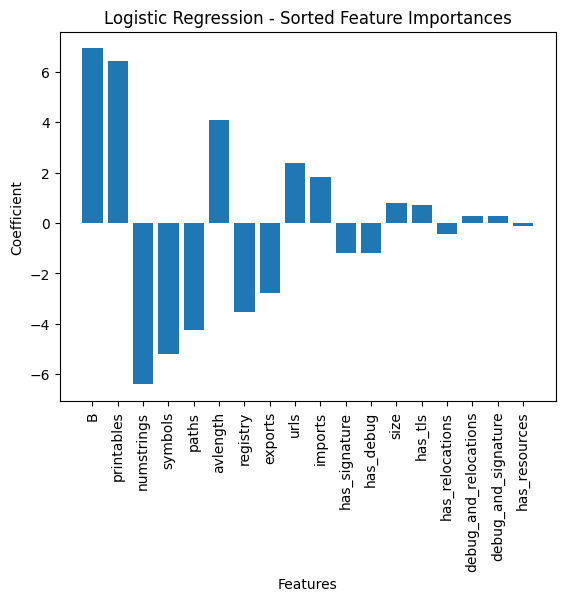

In [24]:
# Define the parameter grid
param_grid_lr = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1,0.3,0.5,1],
    'solver': ['saga'],
    'max_iter': [1000]
}

# Create the logistic regression model
lr = LogisticRegression()

# Create the GridSearchCV object
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr,cv=5, n_jobs=2,scoring = 'roc_auc')

# Fit the GridSearchCV object to the training data
grid_search_lr.fit(X_train, y_train)

# Get the best estimator (fitted model) from GridSearchCV
best_lr = grid_search_lr.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters: ", grid_search_lr.best_params_)

# Get feature importances
lr_coefs = best_lr.coef_[0]
sorted_indices = np.argsort(np.abs(lr_coefs))[::-1]
sorted_coefs = lr_coefs[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

# Plot sorted feature importances
plt.bar(range(len(sorted_coefs)), sorted_coefs)
plt.xticks(range(len(sorted_coefs)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Logistic Regression - Sorted Feature Importances')
plt.show()


In [25]:
# Get AUC score on the validation set
y_pred_lr = best_lr.predict_proba(X_validation)[:, 1]  # Assuming binary classification
auc_score_lr = roc_auc_score(y_validation, y_pred_lr)
print("AUC Score on Validation Set: ", auc_score_lr)

AUC Score on Validation Set:  0.7775949482427791


In [26]:
param_grid_knn = {
            'algorithm': ['auto'],
            'n_neighbors':[5,30,50,80,100,130,150],
            'weights':['uniform','distance']
            }

# Create the KNN classifier
knn = KNeighborsClassifier()

# Perform grid search
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, 
                  scoring='roc_auc', cv=5, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Get the best estimator (fitted model) from GridSearchCV
best_knn = grid_search_knn.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters: ", grid_search_knn.best_params_)




Best Hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 30, 'weights': 'distance'}


In [27]:
y_validation_proba_knn = best_knn.predict_proba(X_validation)[:, 1]
auc_score_knn = roc_auc_score(y_validation, y_validation_proba_knn)
print("AUC Score on Validation Set: ", auc_score_knn)

AUC Score on Validation Set:  0.9222098904317703


KNN doesn't provide a built-in feature importance measure, as it's a non-parametric algorithm that doesn't assign weights or coefficients to features. However, we can use the feature importance provided by the "SelectKBest" feature selection method in combination with KNN.

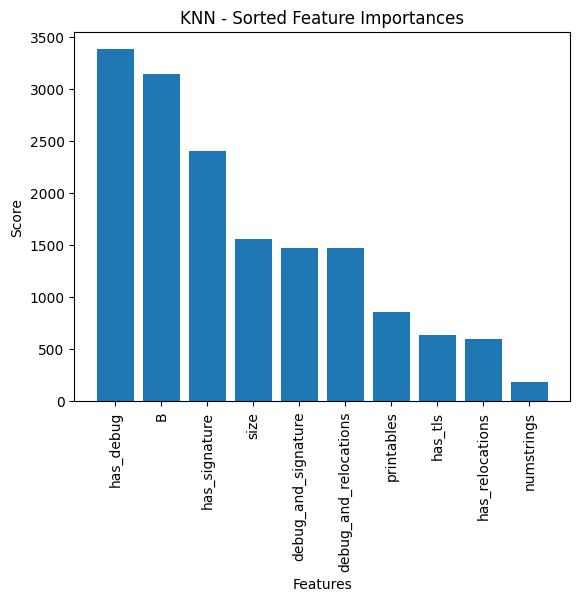

In [28]:
# Perform feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train, y_train)
selected_feature_indices = selector.get_support(indices=True)

# Get sorted feature importances
sorted_scores = selector.scores_[selected_feature_indices]
sorted_indices = np.argsort(sorted_scores)[::-1]
sorted_scores = sorted_scores[sorted_indices]
sorted_feature_names = feature_names[selected_feature_indices][sorted_indices]

# Plot sorted feature importances
plt.bar(range(len(sorted_scores)), sorted_scores)
plt.xticks(range(len(sorted_scores)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('KNN - Sorted Feature Importances')
plt.show()

### Advanced Models

After using using a simpler linear model (Logistic Regression) and an instance-based model (K-Nearest Neighbors), we use more advanced models.

3. Random Forest: 

Hyperparameters:

    n_estimators: Balances model robustness against overfitting and resource demand. Higher values increase model complexity (lower bias, higher variance). 

    max_depth: Controls decision tree complexity. Higher values can capture more intricate patterns but may lead to overfitting (higher variance, lower bias).

    min_samples_split and min_samples_leaf: These parameters determine the minimum number of samples required to split an internal node (min_samples_split) and the minimum number of samples required to be at a leaf node (min_samples_leaf). Increasing these values can regularize the model and prevent overfitting by enforcing a higher threshold for creating new splits or leaf nodes. Higher values reduce the model's capacity to learn intricate patterns from the training data, increasing bias and potentially reducing variance.

    max_features: The number of features to consider when looking for the best split. Adding more features can increase model complexity (lower bias, higher variance), but it may also increase the risk of overfitting. On the other hand, reducing the number of considered features can smooth the decision boundary and increase bias, potentially improving model robustness. 

    Criterion: Entropy as a splitting criterion tends to create more complex decision boundaries and can capture intricate patterns in the data. By using entropy, the Random Forest model aims to minimize the disorder or uncertainty in the resulting partitions. This can lead to more accurate predictions on the training data. However, prioritizing entropy can potentially increase the model's variance. With a more complex decision boundary, the model becomes more flexible and has a higher capacity to fit the training data. This increased flexibility can result in overfitting, where the model becomes too specific to the training data and performs poorly on unseen data. 


4. Multi-Layer Perceptron (ANN): 

Hyperparameters:

    hidden_layer_sizes: Balances capability to model complex patterns against overfitting. More neurons/layers increase model complexity (lower bias, higher variance).

    activation: Determines the type of non-linearity introduced to the model. We used the non-linear activation function reLu, which is commonly used

    solver: 'sgd' (Stochastic Gradient Descent):  We used stochastic gradient descent as the optimization algorithm. It updates the weights of the network based on the gradients of the error function calculated on a small subset of the training data (mini-batch). When using 'sgd', the model can adapt more flexibly to the training data. It has the ability to quickly respond to new patterns or changes in the data, which helps reduce bias. However, because 'sgd' updates the weights using small subsets of the data, it introduces randomness or variability in the weight updates. This stochastic (random) nature of the updates can increase the variance of the model. 

    alpha: L2 regularization term to prevent overfitting (reduces variance, increases bias).

    learning_rate: Balances the speed of convergence against the risk of overshooting optimal solution.

    max_iter: Controls the number of training epochs. Too many may lead to overfitting, too few to underfitting.


For each of these models, we used K-fold cross validation and GridSearch or RandomizedSearch to find the best hyperparameters with respect to AUC. The results are:

Random Forest: (max_depth = 50, max_features = 'auto', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 1000,criterion = 'entropy')

    AUC: about 0.96

MLP: (activation='relu', solver='sgd', alpha=0.0001, learning_rate='constant',hidden_layer_sizes=(200,),max_iter=300)

    AUC: about 0.8

With these results, we will choose Random Forest as our prediction model for the rest of the project.



### Random Forest

In [29]:
# Define the parameter grid
param_grid_forest = {
    'n_estimators': [750, 1000, 1300],
    'max_depth': [20, 30, 50],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto'],
    'criterion': ['entropy']
}

# Create the model
forest = RandomForestClassifier(random_state=0)

# Create the RandomizedSearchCV object
random_search_forest = RandomizedSearchCV(estimator=forest, param_distributions=param_grid_forest, 
                                          scoring='roc_auc', cv=5, n_jobs=-1, n_iter=10, random_state=0)

# Fit the RandomizedSearchCV object to the data
random_search_forest.fit(X_train, y_train)

# Get the best estimator (fitted model) from RandomizedSearchCV
best_forest = random_search_forest.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters:", random_search_forest.best_params_)


Best Hyperparameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy'}


In [30]:
# Calculate AUC for best Random Forest
y_pred_forest = best_forest.predict_proba(X_validation)[:, 1]
auc_forest = roc_auc_score(y_validation, y_pred_forest)
print("AUC for Random Forest: ", auc_forest)


AUC for Random Forest:  0.9606298428637529


Random forests have a built-in feature importance measure based on the mean decrease impurity or Gini importance. We can access and visualize the feature importances using the feature_importances_ attribute.

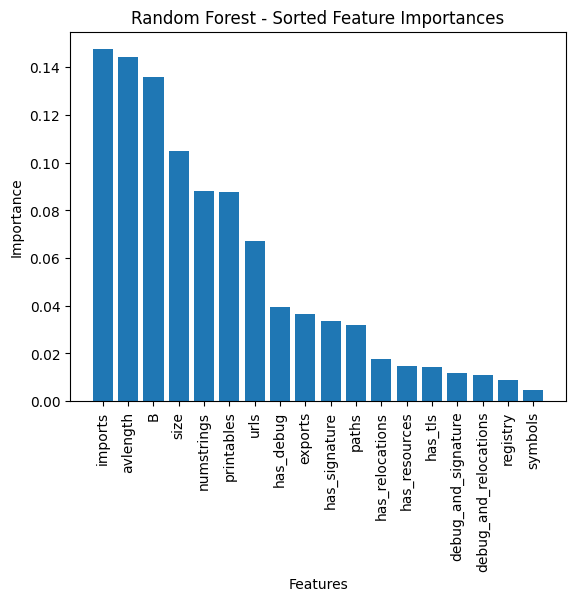

In [31]:
# Get feature importances
rf_importances = best_forest.feature_importances_
sorted_indices = np.argsort(rf_importances)[::-1]
sorted_importances = rf_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot sorted feature importances
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest - Sorted Feature Importances')
plt.show()

### MLP

In [32]:
# Define the parameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],
    'activation': ['relu'],
    'solver': ['sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant'],
    'max_iter': [200, 300]
}

# Create the MLP model
mlp_model = MLPClassifier()

# Create the GridSearchCV object
grid_search_mlp = GridSearchCV(estimator=mlp_model, param_grid=param_grid_mlp, scoring='roc_auc', cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search_mlp.fit(X_train, y_train)

# Get the best estimator (fitted model) from GridSearchCV
best_mlp = grid_search_mlp.best_estimator_

# Print the best hyperparameters found
print("Best Hyperparameters: ", grid_search_mlp.best_params_)

Best Hyperparameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (200,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'sgd'}


In [33]:
# Calculate the validation AUC score for MLP
y_test_pred_mlp = best_mlp.predict_proba(X_validation)[:, 1]
auc_mlp = roc_auc_score(y_validation, y_test_pred_mlp)
print("AUC for MLP: ", auc_mlp)

AUC for MLP:  0.7912870966752614


MLP models don't have a direct built-in feature importance measure like random forests. However, we can approximate feature importance using techniques such as permutation importance. 

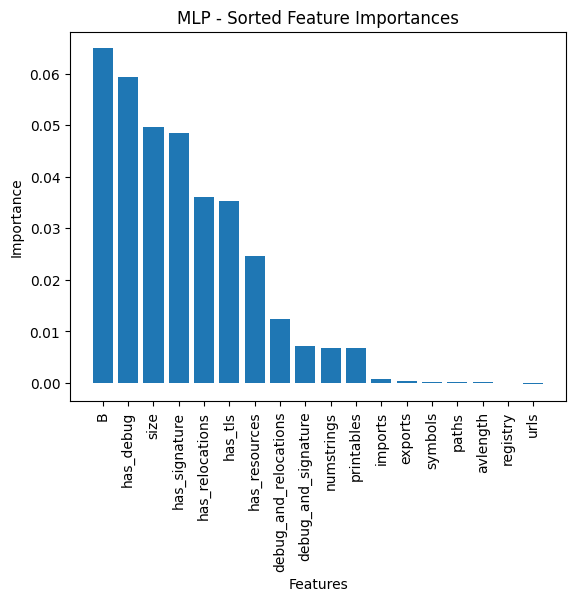

In [34]:
# Perform permutation importance testing
perm_importance = permutation_importance(best_mlp, X_train, y_train, n_repeats=10, random_state=0)

# Get feature importances
mlp_importances = perm_importance.importances_mean
sorted_indices = np.argsort(mlp_importances)[::-1]
sorted_importances = mlp_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot sorted feature importances
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('MLP - Sorted Feature Importances')
plt.show()

Top 5 Features: has_debug,B,has_tls,has_signature,debug_and_signature

#### Feature Importance: 

    Logistic regression Top 5 Features: registry,paths,avlength,symbols,printables

    KNN Top 5 Features: has_debug,B,has_signature,size,debug_and_signature

    random Forest Top 5 Features: imports,B,avlength,size,numstrings

    MLP Top 5 Features: has_debug,B,has_tls,has_signature,debug_and_signature

Based on the given feature descriptions, we can make the following observations regarding the top 5 features for each model:

Logistic Regression:
Since we used coefficients, if the high and positive values for a feature indicate that as that feature grows (or is 1 in the case of binary) the probability of malware increases. In the same way, if the coefficient is low and negative,this indicates that as that feature grows (or is 1 in the case of binary) the probability of malware decreases. This can be seen for example for "registry" and "paths" . This means that as the number of occurences of HKEY_  and the number of paths ("C:\") increase, the probablity of malware dramatically decreases. In the same way, as average string length increases the probablity of malware increases.

K-Nearest Neighbors (KNN):
KNN does not have a direct feature importance metric, but there is some intuition regarding 'size'. The size of a file can definitely impact its safety, as larger files can contain additional suspicious aspects in comparison so safe files.


Random Forest:
Using Random Forest's built in feature importance, we can gather a couple of intersting insights. "avlength" significance makes sense as seen in Logisitic Regression. In addition, the number of imports and average length of strings show that they are signifiant, which also makes sense considering malicious files can contain many suspicious imports and strings in comparision to safe files.

MLP:
Significant features here are all binary (except for "B", but we will address this later). These binary features indicate presence of certain aspects in the data. For example, it can be seen in the graph that the presence or absence of a debug section, thread local storage, and a signature (as well as signature + debug) is significant in regards to MLP determining malicious files. The most intuitive explanation here can be said for debug, as the presence of a debug section can surely detect any suspicious sections of a file.

Regarding "B", this feature is still unknown yet persists to have a strong value in prediction. This feature is continious, and therefore is likely to be a numeric measure of significant value.  Therefore, we chose to keep it in our final model.

## Part 4: Testing our Model

## Confusion Matrices


A confusion matrix is a table often used to describe the performance of a classification model on a set of test data for which the true values are known. It has four cells each representing a different kind of prediction:

True Positives (TP): The instances that were positive and the model predicted as positive.

True Negatives (TN): The instances that were negative and the model predicted as negative.

False Positives (FP): The instances that were negative but the model predicted as positive.

False Negatives (FN): The instances that were positive but the model predicted as negative.

The confusion matrix not only gives us an idea about how our model performs, but also helps us to understand the types of errors made by our model.

Our chosen model (Random Forest) is used for the confusion matrices below.

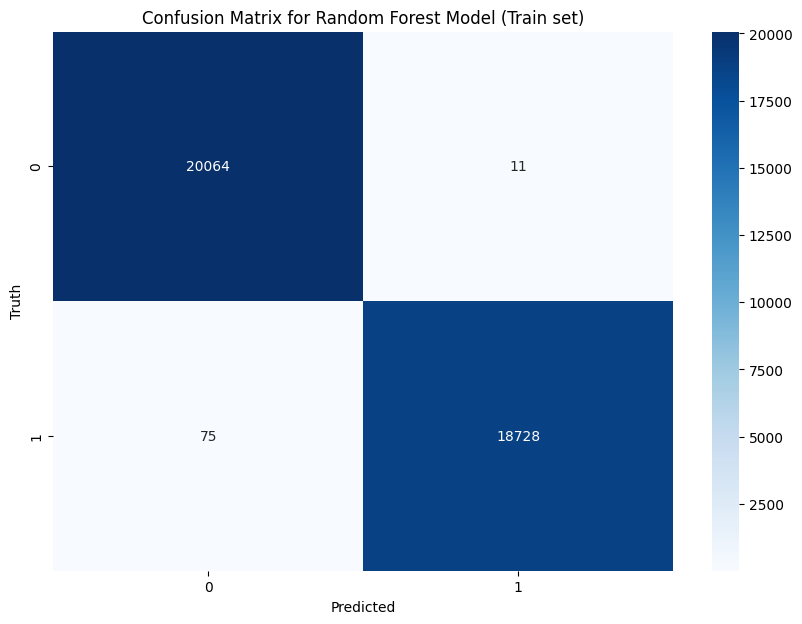

Accuracy (Train Set): 0.9977879520551469
Precision (Train Set): 0.9994129889535194
Recall (Train Set): 0.996011274796575
Specificity (Train Set): 0.9994520547945206


In [36]:
#train matrix
y_pred = best_forest.predict(X_train)

# Calculate the confusion matrix train
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Random Forest Model (Train set)')
plt.show()

# Calculate the performance metrics
tp = cm[1, 1]  # True positives
tn = cm[0, 0]  # True negatives
fp = cm[0, 1]  # False positives
fn = cm[1, 0]  # False negatives

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Accuracy (Train Set):", accuracy)
print("Precision (Train Set):", precision)
print("Recall (Train Set):", recall)
print("Specificity (Train Set):", specificity)


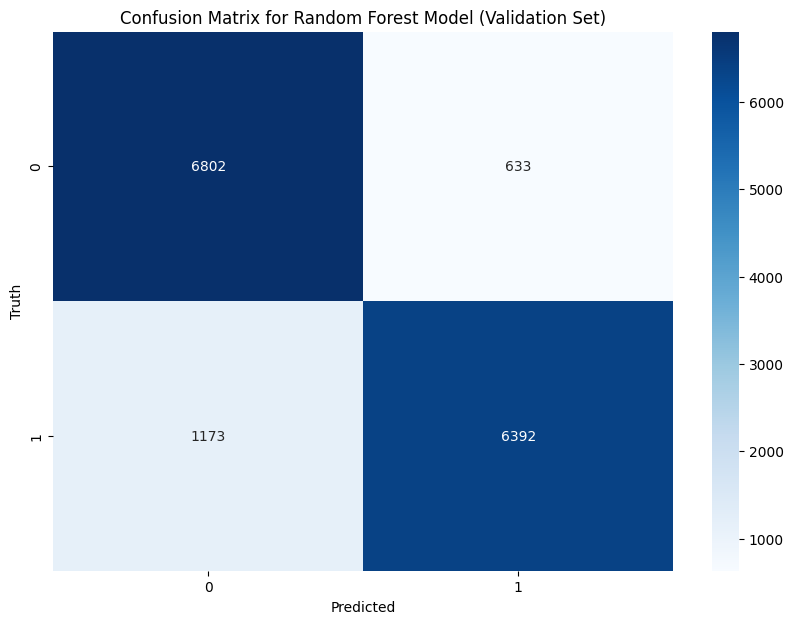

Accuracy (Validation Set): 0.8796
Precision (Validation Set): 0.9098932384341637
Recall (Validation Set): 0.8449438202247191
Specificity (Validation Set): 0.914862138533961


In [35]:
# Predict on the validation set
y_pred_val = best_forest.predict(X_validation)

# Calculate the confusion matrix for validation set
cm_val = confusion_matrix(y_validation, y_pred_val)

# Plot the confusion matrix for validation set
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix for Random Forest Model (Validation Set)')
plt.show()

# Calculate the performance metrics for validation set
tp_val = cm_val[1, 1]  # True positives
tn_val = cm_val[0, 0]  # True negatives
fp_val = cm_val[0, 1]  # False positives
fn_val = cm_val[1, 0]  # False negatives

accuracy_val = (tp_val + tn_val) / (tp_val + tn_val + fp_val + fn_val)
precision_val = tp_val / (tp_val + fp_val)
recall_val = tp_val / (tp_val + fn_val)
specificity_val = tn_val / (tn_val + fp_val)

print("Accuracy (Validation Set):", accuracy_val)
print("Precision (Validation Set):", precision_val)
print("Recall (Validation Set):", recall_val)
print("Specificity (Validation Set):", specificity_val)


Results: 

For Validation Set:

    Accuracy:  This shows the proportion of the total number of predictions that were correct.
    Despite this, we learned in class that in classification models, we do not look at accuracy. (For example, if the dataset has 95% instances of Class A and only 5% instances of Class B, a naive classifier that always predicts Class A would achieve 95% accuracy but fail to capture the minority class.)

    Precision (Positive Predictive Value):  This shows the proportion of positive predictions that were correct. In other words, when the model predicted an instance to be malicious, it was correct 90% of the time.

    Recall (Sensitivity, True Positive Rate): This shows the proportion of actual positive instances that were correctly identified by the model. In other words, the model correctly identified 84% of the actual malicious instances.

    Specificity (True Negative Rate):  This shows the proportion of actual negative instances that were correctly identified by the model. In other words, the model correctly identified 91% of the actual non-malicious instances.

    This allows us to understand the performance of the model:

    These metrics collectively provide insights into the performance of the model. While accuracy is often used as a general indicator, it may not provide a complete picture, especially in imbalanced datasets. Precision and recall provide more specific information about the model's performance on positive instances, while specificity focuses on negative instances. 



## K-Fold Cross Validation

For K-Fold Cross Validation, we'll split our data into k subsets (or "folds") and train each model k times, each time using a different fold as our validation set and the remaining folds as our training set. This gives us a more robust measure of our model's performance.

The Receiver Operating Characteristic (ROC) curve is a plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

Here we compare the results for all 4 models


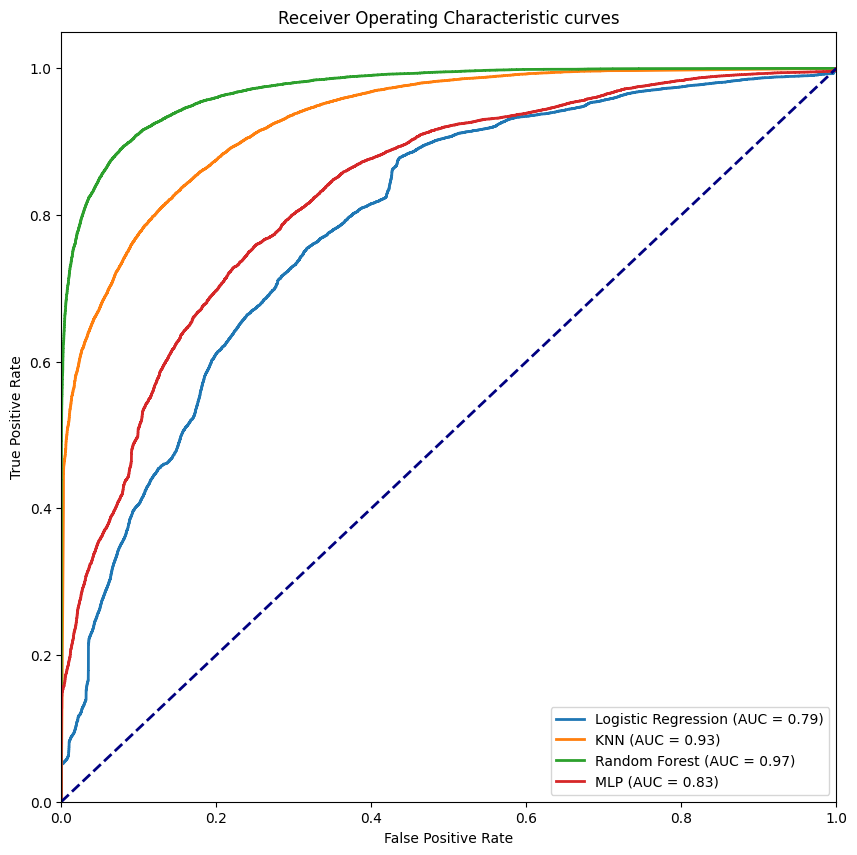

In [37]:
# List of models
models = [best_lr, best_knn, best_forest, best_mlp]
model_names = ['Logistic Regression', 'KNN', 'Random Forest', 'MLP']

# Define a colormap
cmap = plt.get_cmap('tab10')

plt.figure(figsize=(10,10))
for i, model in enumerate(models):
    y_pred = cross_val_predict(model, X_train, y_train, cv=5, method="predict_proba")[:,1]
    fpr, tpr, _ = roc_curve(y_train, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=cmap(i), lw=2, label='%s (AUC = %0.2f)' % (model_names[i], roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curves')
plt.legend(loc="lower right")
plt.show()



These results continue to show that choosing Random Forest over other models was the right decision.

### Overfitting

Overfitting occurs when the model performs significantly better on the training set than on the validation set or unseen data. This usually indicates that the model has learned the noise in the training data to the point where it negatively impacts the performance on new data.

In our Random Forest model that we chose, we believe that overfitting is not an issue. We can observe our confusion matrices (for Train and Validation) to see that there is a significant gap between the performance on the training set and the validation set. The model performs exceptionally well on the training data but slightly worse on the validation data. This may indicate a certain degree of overfitting, where the model has learned the training data very well but is not as good at generalizing to unseen data. Despite this, the model's performance on the validation set is still quite good, suggesting that the degree of overfitting is not severe


# Part 5: Prediction

We will now use the random forest model to calculate a prediction.

In [38]:
def predict_Validation(X_train, X_validation, y_train, y_validation):

    # Define the parameter grid
    param_grid_forest = {
        'n_estimators': [750, 1000, 1300],
        'max_depth': [20, 30, 50],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto'],
        'criterion': ['entropy']
    }

    # Create the model
    forest = RandomForestClassifier(random_state=0)

    # Create the RandomizedSearchCV object
    random_search_forest = RandomizedSearchCV(estimator=forest, param_distributions=param_grid_forest, 
                                            scoring='roc_auc', cv=5, n_jobs=-1, n_iter=10, random_state=0)

    # Fit the RandomizedSearchCV object to the data
    random_search_forest.fit(X_train, y_train)

    # Get the best estimator (fitted model) from RandomizedSearchCV
    best_forest = random_search_forest.best_estimator_

    # Predict probabilities for the validation set
    y_validation_proba = best_forest.predict_proba(X_validation)[:, 1]  

    # Calculate AUC for the validation set
    validation_auc = roc_auc_score(y_validation, y_validation_proba)

    print(f'Validation AUC: {validation_auc:.2f}')


predict_Validation(X_train, X_validation, y_train, y_validation)






Validation AUC: 0.96


This function is for calculating the same prediction on the test set later

In [39]:
def predict_test(X_train, X_test, y_train,sha256):

    # Define the parameter grid
    param_grid_forest = {
        'n_estimators': [750, 1000, 1300],
        'max_depth': [20, 30, 50],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto'],
        'criterion': ['entropy']
    }

    # Create the model
    forest = RandomForestClassifier(random_state=0)

    # Create the RandomizedSearchCV object
    random_search_forest = RandomizedSearchCV(estimator=forest, param_distributions=param_grid_forest, 
                                            scoring='roc_auc', cv=5, n_jobs=-1, n_iter=10, random_state=0)

    # Fit the RandomizedSearchCV object to the data
    random_search_forest.fit(X_train, y_train)

    # Get the best estimator (fitted model) from RandomizedSearchCV
    best_forest = random_search_forest.best_estimator_

    # Predict probabilities for the test set
    y_test_proba = best_forest.predict_proba(X_test)[:, 1]  

    # Create a DataFrame with the sha256 and the predicted probabilities
    results_df = pd.DataFrame({
    'sha256': sha256,  
    'predict_proba': y_test_proba
    })

    # Save the DataFrame to a CSV file
    results_df.to_csv('results_33.csv', index=False)


## Improving AUC

After all these steps, we receive an AUC result of 0.96. This is a high result, but we believe we can improve upon it. We will now go back to preprocessing to change methods we already calculated.

In [68]:
#read the data
train_raw = pd.read_csv("train.csv")
X_train_raw = train_raw.iloc[:,1:-1]
Y_train_raw = train_raw.iloc[:,-1]

# Split the data into train and test sets
X_train, X_validation, y_train, y_validation = train_test_split(X_train_raw,Y_train_raw)

We believe that the first change that could benefit our model is bringing back file_type_trid, a complicated categorial feature that we originally removed as to get to a fast AUC. What we will try now is using the percentages created in our visualization process to create categories of files for One-Hot Encoding. In addition, we will do the same with "C".

One-Hot Encoding: 

In [84]:
# Define the file types
file_types = [
    'Win64 Executable (generic)',
    'Win32 Executable MS Visual C++ (generic)',
    'Win32 Executable (generic)',
    'Win32 Dynamic Link Library (generic)',
    'Generic CIL Executable (.NET, Mono, etc.)',
    'Windows Control Panel Item (generic)',
    'InstallShield setup',
    'UPX compressed Win32 Executable',
    'DOS Executable Generic',
    'Win32 Executable Microsoft Visual Basic 6',
    'OS/2 Executable (generic)',
    'Win32 EXE PECompact compressed (generic)',
    'Generic .NET DLL/Assembly',
    'WinRAR Self Extracting archive (4.x-5.x)',
    'NSIS - Nullsoft Scriptable Install System',
    'Microsoft Visual C++ compiled executable (generic)',
    'Win32 Executable Delphi generic',
    'Inno Setup installer',
    'Win16 NE executable (generic)',
    'Windows ActiveX control'
]

C_types = ['vh','er','cs','bf', 'gow', 'mc', 'vr']


def one_hot_encoding_with_prob_threshold(X, file_types, threshold=.70):
    # Create a new column with file types categorized as 'Other'
    X['file_type_encoded'] = X['file_type_trid'].apply(
        lambda x: x if x in file_types else 'Other'
    )

    # Create binary encoding columns for each file type
    for file_type in file_types:
        X[file_type] = ((X['file_type_encoded'] == file_type) & (X['file_type_prob_trid'] > threshold)).astype(int)

    # Create a binary column for 'Other' file types
    X['Other'] = ((X['file_type_encoded'] == 'Other') & (X['file_type_prob_trid'] > threshold)).astype(int)

    # Drop the unnecessary columns
    X_encoded = X.drop(['file_type_trid', 'file_type_encoded', 'file_type_prob_trid'], axis=1)

    return X_encoded

def one_hot_encoding_C(X, C_types):
    # Create binary encoding columns for each C_type
    for C_type in C_types:
        X[C_type] = (X['C'] == C_type).astype(int)

    # Drop the unnecessary columns
    X_encoded = X.drop(['C'], axis=1)

    return X_encoded



The file_type_prob_trid feature indicates the probability that the given file type (specified in file_type_trid) is correct. We utilized this information to create a weighted version of one-hot encoding.

In this code, a new binary column is created for each file type, which is 1 if file_type_prob_trid is greater than the provided threshold (70%), and 0 otherwise. This helps to highlight instances where a certain file type is highly probable.

Now we will add this to our final pipeline and explore the results

In [70]:
#run new preprocess on train
def train_preprocess(X_train,y_train,numerical_features_list,file_types,C_types):
    #check if order changes AUC
    X_train, y_train = mad(X_train, y_train) 
    X_train = feature_engineering(X_train)
    X_train,min_dict,max_dict = normalize_train(X_train,numerical_features_list)
    X_train = one_hot_encoding_with_prob_threshold(X_train,file_types)
    X_train = one_hot_encoding_C(X_train, C_types)
    X_train,mean_dict = fill_na_mean_train(X_train)
    selected_features = backward_elimination(X_train,y_train)
    X_train = reduced_dimension_df(X_train,selected_features)

    return X_train,y_train,min_dict,max_dict,mean_dict,selected_features

X_train,y_train,min_dict,max_dict,mean_dict,selected_features = train_preprocess(X_train,y_train,numerical_features_list,file_types,C_types)


In [71]:
#validation new preprocess
def validation_preprocessing(X_val,file_types,C_types,numerical_features_list,min_dict,max_dict,mean_dict,selected_features):
    val_preprocessed = feature_engineering(X_val)
    #normalize
    val_preprocessed = normalize_test(val_preprocessed,numerical_features_list,min_dict,max_dict)
    #one_hot
    val_preprocessed = one_hot_encoding_with_prob_threshold(val_preprocessed,file_types)
    val_preprocessed = one_hot_encoding_C(val_preprocessed, C_types)\
    #fill_na
    val_preprocessed = fill_na_mean_test(val_preprocessed,mean_dict)
    #dimensionality reduction
    val_preprocessed = reduced_dimension_df(val_preprocessed,selected_features)
    
    return val_preprocessed

validation_preprocessed = validation_preprocessing(X_validation,file_types,C_types,
numerical_features_list,min_dict,max_dict,mean_dict,selected_features)  



In [58]:
X_validation = validation_preprocessed.copy()



In [59]:
predict_Validation(X_train, X_validation, y_train, y_validation)

Validation AUC: 0.96


These results remain the same, yet we believe that they are more accurate in using all the given features properly instead of simply removing them. Therefore, we will include this in our final pipeline.

We need this function to cleanly preprocess the test file

In [64]:
def preprocessing_test(X_test, numerical_features_list,min_dict,max_dict,mean_dict,selected_features,C_types,file_types):
    test_preprocessed = X_test.copy()
    
    test_preprocessed = feature_engineering(test_preprocessed)
    #normalize
    test_preprocessed = normalize_test(test_preprocessed,numerical_features_list,min_dict,max_dict)
    #one_hot
    test_preprocessed = one_hot_encoding_with_prob_threshold(test_preprocessed,file_types)
    test_preprocessed = one_hot_encoding_C(test_preprocessed, C_types)
    #fill_na
    test_preprocessed = fill_na_mean_test(test_preprocessed,mean_dict)
    # #dimensionality reduction
    test_preprocessed = reduced_dimension_df(test_preprocessed,selected_features)

    return test_preprocessed


# Final Pipeline




This code loads the necessary data, performs preprocessing per dataset and predicts the final test result. This result is sent to a csv file, categorized per sha246 ID and its prediction probability.

In [85]:
def Pipeline(numerical_features_list,file_types,C_types):
    train = pd.read_csv("train.csv")
    X_train = train.iloc[:,1:-1]
    y_train = train.iloc[:,-1]
    
    test = pd.read_csv("test.csv")
    sha256_test = test.iloc[:,0]
    X_test = test.iloc[:,1:]
    y_test = test.iloc[:,-1]
    
   
    X_train,y_train,min_dict,max_dict,mean_dict,selected_features = train_preprocess(X_train,y_train,numerical_features_list,file_types,C_types)
    X_test = preprocessing_test(X_test,numerical_features_list,min_dict,max_dict,mean_dict,selected_features,C_types,file_types)
    predict_test(X_train, X_test, y_train, y_test,sha256_test)
    
    
Pipeline(numerical_features_list,file_types,C_types)

    
    